In [15]:
# Importar bibliotecas necesarias
import os
import sys
import pandas as pd
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Configurar el path para encontrar los módulos
current_dir = os.path.dirname(os.path.abspath('__file__'))
src_dir = os.path.abspath(os.path.join(current_dir, '..'))
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)
print(f"Directorio src agregado al path: {src_dir}")

# Cargar variables de entorno
env_path = os.path.join(os.path.dirname(src_dir), '.env')
load_dotenv(env_path)
print(f"Archivo .env cargado desde: {env_path}")

Directorio src agregado al path: c:\Users\Claudia\Documents\GitHub\GPTur\src
Archivo .env cargado desde: c:\Users\Claudia\Documents\GitHub\GPTur\.env


In [16]:
# Verificar la configuración del entorno
def check_environment():
    checks = {
        "Python Path": src_dir in sys.path,
        "Módulo agents": False,
        "Módulo chatbot": False,
        "Módulo vector_db": False,
        ".env file": os.path.exists(env_path),
        "questions.csv": os.path.exists('questions.csv')
    }
    
    try:
        import agents
        checks["Módulo agents"] = True
    except ImportError as e:
        print(f"Error importando agents: {e}")
        
    try:
        import chatbot
        checks["Módulo chatbot"] = True
    except ImportError as e:
        print(f"Error importando chatbot: {e}")
        
    try:
        import vector_db
        checks["Módulo vector_db"] = True
    except ImportError as e:
        print(f"Error importando vector_db: {e}")
    
    print("\n=== Verificación del Entorno ===")
    all_passed = True
    for check, passed in checks.items():
        status = "✓" if passed else "✗"
        if not passed:
            all_passed = False
        print(f"{status} {check}")
    
    if not all_passed:
        print("\n⚠ Hay problemas en la configuración que deben ser resueltos")
    else:
        print("\n✓ Todo está correctamente configurado")
    
    return all_passed

# Ejecutar verificación
environment_ok = check_environment()


=== Verificación del Entorno ===
✓ Python Path
✓ Módulo agents
✓ Módulo chatbot
✓ Módulo vector_db
✗ .env file
✗ questions.csv

⚠ Hay problemas en la configuración que deben ser resueltos


In [17]:
# Importar el chatbot y sus componentes
from agents.agent_manager import AgentManager
from chatbot.core import CubaChatbot
from vector_db.chroma_storage import VectorStorage
from chatbot.core import CubaChatbot
from chatbot.gap_detector import GapDetector
from crawlers.dynamic_crawler import DynamicCrawler
from agents.retriever_agent import RetrieverAgent
from agents.generator_agent import GeneratorAgent
from agents.gap_detector_agent import GapDetectorAgent
from agents.updater_agent import UpdaterAgent
from agents.agent_manager import AgentManager
from agents.guide_agent import GuideAgent
from agents.planner_agent import TravelPlannerAgent, StochasticPrice, Place

# Inicializar el chatbot
def initialize_chatbot():
    try:
        print("\nInicializando Chatbot...")
        chatbot = CubaChatbot()
        print("Chatbot inicializado correctamente")
        
        return chatbot
    except ImportError as e:
        print(f"\nError de importación: {str(e)}")
        print("Verifica que:")
        print("1. Estás en el directorio correcto")
        print("2. El directorio 'src' está en el Python path")
        print(f"3. Los módulos están disponibles en: {src_dir}")
        return None
    except Exception as e:
        print(f"\nError inesperado: {str(e)}")
        print(f"Tipo de error: {type(e).__name__}")
        import traceback
        print("\nDetalles del error:")
        print(traceback.format_exc())
        return None

# Inicializar el chatbot
print("=== Iniciando configuración del chatbot ===")
chatbot = initialize_chatbot()

if chatbot is not None:
    print("\n✓ Chatbot inicializado exitosamente")
    print(f"Tipo de chatbot: {type(chatbot).__name__}")
else:
    print("\n✗ Error al inicializar el chatbot")

=== Iniciando configuración del chatbot ===

Inicializando Chatbot...
Chatbot inicializado correctamente

✓ Chatbot inicializado exitosamente
Tipo de chatbot: CubaChatbot


In [18]:
planner_agent = TravelPlannerAgent(chatbot.vector_db)

In [19]:
# 1. Configuración inicial del problema
def generate_test_places(num_gastronomicos=15, num_nocturnos=10, num_alojamientos=8):
    places = {
        "gastronomicos": [
            Place(
                name=f"Restaurante {i}",
                city="TestCity",
                cost=StochasticPrice(base_price=random.uniform(10, 30)),
                final_cost=0.0,
                rating=random.uniform(7, 10),
                type="restaurant"
            ) for i in range(num_gastronomicos)
        ],
        "nocturnos": [
            Place(
                name=f"Club {i}",
                city="TestCity",
                cost=StochasticPrice(base_price=random.uniform(15, 40)),
                final_cost=0.0,
                rating=random.uniform(7, 10),
                type="nightlife"
            ) for i in range(num_nocturnos)
        ],
        "alojamientos": [
            Place(
                name=f"Hotel {i}",
                city="TestCity",
                cost=StochasticPrice(base_price=random.uniform(40, 100)),
                final_cost=0.0,
                rating=random.uniform(7, 10),
                type="lodging"
            ) for i in range(num_alojamientos)
        ]
    }
    return places

In [20]:
# 2. Función para ejecutar experimentos
def run_experiment(T, alpha, days=5, budget_per_day=150, n_runs=10):
    results = {
        "best_ratings": [],
        "feasible_solutions": 0,
        "convergence_data": [],
        "execution_times": []
    }
    
    test_places = generate_test_places()
    
    for _ in range(n_runs):
        start_time = time.time()
        
        # Ejecutar SA
        agent = TravelPlannerAgent(vector_db=None)
        solution = agent.simulated_annealing_csp(
            days=days,
            places=test_places,
            budget_per_day=budget_per_day,
            destination="TestCity",
            max_iter=1000,
            max_time=180,
            T=T,
            alpha=alpha
        )
        
        # Calcular calidad de la solución
        rating = agent.evaluate(solution, n=30)
        results["best_ratings"].append(rating)
        
        # Verificar factibilidad
        feasible = agent.is_valid_solution(solution, budget_per_day)
        results["feasible_solutions"] += int(feasible)
        
        # Tiempo de ejecución
        results["execution_times"].append(time.time() - start_time)
    
    return results

In [21]:
# 3. Diseño experimental completo
param_grid = {
    "T": [100],
    "alpha": [0.99]
}

experiment_results = []

for T in param_grid["T"]:
    for alpha in param_grid["alpha"]:
        print(f"Running T={T}, alpha={alpha}...")
        results = run_experiment(T, alpha, n_runs=2)
        
        experiment_results.append({
            "T": T,
            "alpha": alpha,
            "mean_rating": np.mean(results["best_ratings"]),
            "std_rating": np.std(results["best_ratings"]),
            "feasibility_rate": results["feasible_solutions"] / 2,
            "mean_time": np.mean(results["execution_times"])
        })

# Convertir a DataFrame
results_df = pd.DataFrame(experiment_results)

Running T=100, alpha=0.99...
Iniciando recocido simulado para planificar viaje...
Iniciando recocido simulado para planificar viaje...


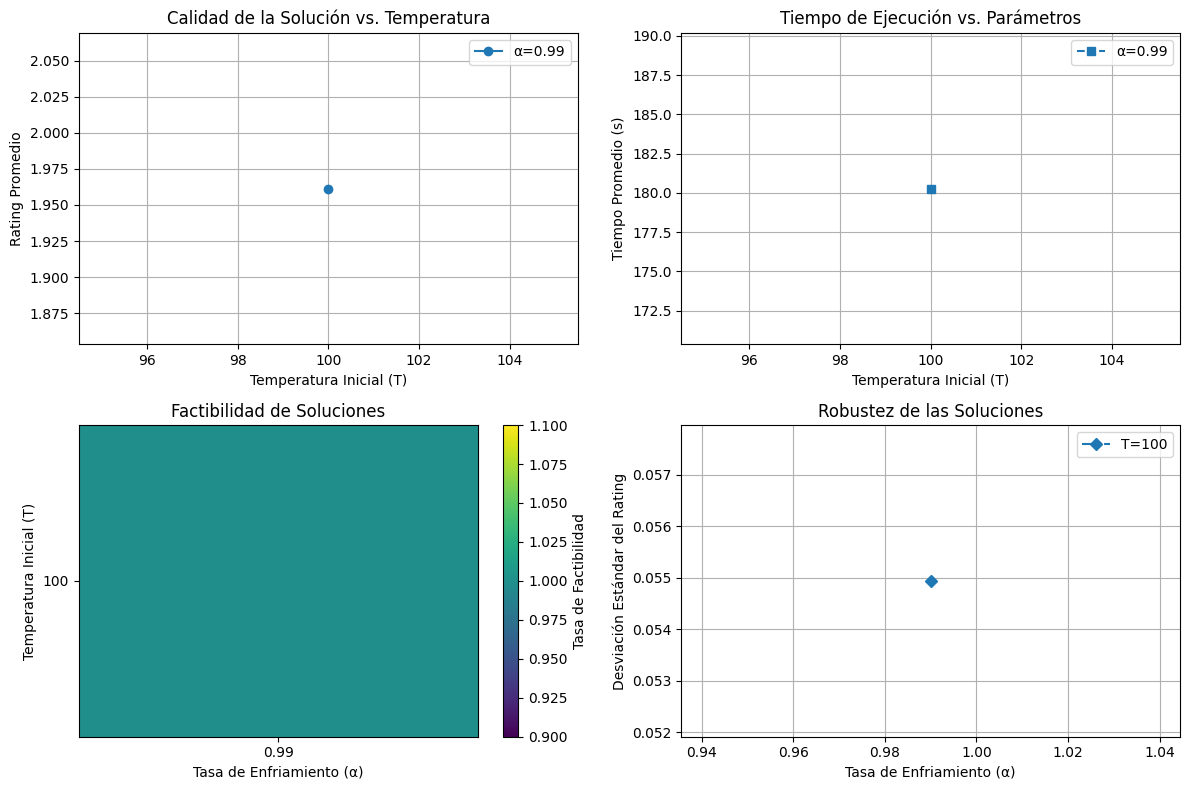

In [22]:
# 4. Visualización de resultados
plt.figure(figsize=(12, 8))

# Gráfico 1: Calidad de solución vs. Parámetros
plt.subplot(2, 2, 1)
for alpha in param_grid["alpha"]:
    subset = results_df[results_df["alpha"] == alpha]
    plt.plot(subset["T"], subset["mean_rating"], 'o-', label=f"α={alpha}")
plt.title("Calidad de la Solución vs. Temperatura")
plt.xlabel("Temperatura Inicial (T)")
plt.ylabel("Rating Promedio")
plt.legend()
plt.grid(True)

# Gráfico 2: Tiempo de ejecución
plt.subplot(2, 2, 2)
for alpha in param_grid["alpha"]:
    subset = results_df[results_df["alpha"] == alpha]
    plt.plot(subset["T"], subset["mean_time"], 's--', label=f"α={alpha}")
plt.title("Tiempo de Ejecución vs. Parámetros")
plt.xlabel("Temperatura Inicial (T)")
plt.ylabel("Tiempo Promedio (s)")
plt.legend()
plt.grid(True)

# Gráfico 3: Factibilidad
plt.subplot(2, 2, 3)
feasibility_matrix = results_df.pivot(index="T", columns="alpha", values="feasibility_rate")
plt.imshow(feasibility_matrix, cmap="viridis", aspect="auto")
plt.colorbar(label="Tasa de Factibilidad")
plt.xticks(np.arange(len(param_grid["alpha"])), param_grid["alpha"])
plt.yticks(np.arange(len(param_grid["T"])), param_grid["T"])
plt.title("Factibilidad de Soluciones")
plt.xlabel("Tasa de Enfriamiento (α)")
plt.ylabel("Temperatura Inicial (T)")

# Gráfico 4: Robustez (desviación estándar)
plt.subplot(2, 2, 4)
for T in param_grid["T"]:
    subset = results_df[results_df["T"] == T]
    plt.plot(subset["alpha"], subset["std_rating"], 'D-.', label=f"T={T}")
plt.title("Robustez de las Soluciones")
plt.xlabel("Tasa de Enfriamiento (α)")
plt.ylabel("Desviación Estándar del Rating")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("parameter_tuning_results.png", dpi=300)
plt.show()


Mejor configuración: T=100.0, α=0.99
Iniciando recocido simulado para planificar viaje...


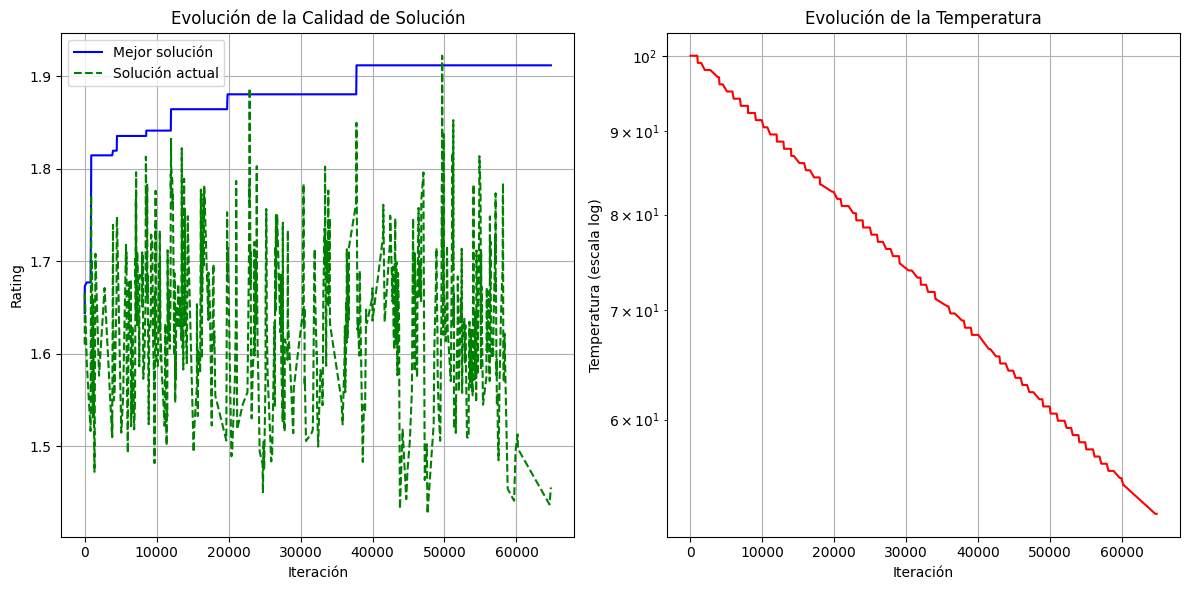


Estadísticas de Convergencia:
Iteraciones Totales: 64784.00
Mejor Rating: 1.91
Tiempo Total: 180.01
Iteracion Mejor Sol: 385.00
Tasa Mejora: 0.14


In [24]:
# 5. Análisis de convergencia (ejemplo para mejor configuración)
best_config = results_df.loc[results_df['mean_rating'].idxmax()]
print(f"\nMejor configuración: T={best_config['T']}, α={best_config['alpha']}")

# Ejecutar con mejor configuración y guardar datos de convergencia
convergence_history = []

def convergence_callback(data):
    """Función que almacena los datos de convergencia"""
    convergence_history.append(data)

# Ejecutar SA con callback
agent = TravelPlannerAgent(vector_db=None)
solution = agent.simulated_annealing_csp(
    days=5,
    places=generate_test_places(),
    budget_per_day=150,
    destination="TestCity",
    T=best_config["T"],
    alpha=best_config["alpha"],
    callback=convergence_callback
)

# Convertir a DataFrame para análisis
conv_df = pd.DataFrame(convergence_history)

# Visualizar convergencia
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(conv_df["iteration"], conv_df["best_rating"], 'b-', label="Mejor solución")
plt.plot(conv_df["iteration"], conv_df["current_rating"], 'g--', label="Solución actual")
plt.xlabel("Iteración")
plt.ylabel("Rating")
plt.title("Evolución de la Calidad de Solución")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.semilogy(conv_df["iteration"], conv_df["temperature"], 'r-')
plt.xlabel("Iteración")
plt.ylabel("Temperatura (escala log)")
plt.title("Evolución de la Temperatura")
plt.grid(True)

plt.tight_layout()
plt.savefig("convergence_analysis.png", dpi=200)
plt.show()

# Analizar estadísticas de convergencia
convergence_stats = {
    "iteraciones_totales": conv_df["iteration"].iloc[-1],
    "mejor_rating": conv_df["best_rating"].max(),
    "tiempo_total": conv_df["time"].iloc[-1],
    "iteracion_mejor_sol": conv_df["best_rating"].idxmax(),
    "tasa_mejora": (conv_df["best_rating"].max() - conv_df["best_rating"].min()) / conv_df["best_rating"].max()
}

print("\nEstadísticas de Convergencia:")
for k, v in convergence_stats.items():
    print(f"{k.replace('_', ' ').title()}: {v:.2f}")

In [25]:
# 6. Resultados numéricos detallados
print("\nResultados detallados:")
print(results_df.sort_values("mean_rating", ascending=False))


Resultados detallados:
     T  alpha  mean_rating  std_rating  feasibility_rate   mean_time
0  100   0.99       1.9613    0.054939               1.0  180.270693
